## Setting the environment

In [1]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate==0.21.0 bitsandbytes

Cloning into 'lora'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 934 (delta 356), reused 307 (delta 307), pack-reused 516
Receiving objects: 100% (934/934), 182.96 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (561/561), done.
Updating files: 100% (60/60), done.
Processing ./lora
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s e

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil
from google.colab import files
from tqdm import tqdm

In [3]:
seed_value=42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

## Renaming the deplicated parameter

In [4]:
file_name = "/content/lora/training_scripts/train_lora_dreambooth.py"

search_text = "logging_dir"
replace_text = "project_dir"

with open(file_name, 'r') as file:
    data = file.read()
    data = data.replace(search_text, replace_text)
with open(file_name, 'w') as file:
    file.write(data)

## Setting the prompt and training

In [5]:
PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
OUTPUT_DIR="" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

Saving spongebob_2.jpg to spongebob_2.jpg
Saving spongebob_3.jpg to spongebob_3.jpg
Saving spongebob_1.jpg to spongebob_1.jpg


  |███████████████| 3/3 Uploaded


In [6]:
PROMPT="SpongeBob"

In [7]:
STEPS = 2500 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-09-07 17:39:32.821316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-09-07 17:39:38.550179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[ 0.0238,  0.0135,  0

## Loading model and monkey patching it

In [8]:
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [10]:
pipe.safety_checker = None

  0%|          | 0/50 [00:00<?, ?it/s]

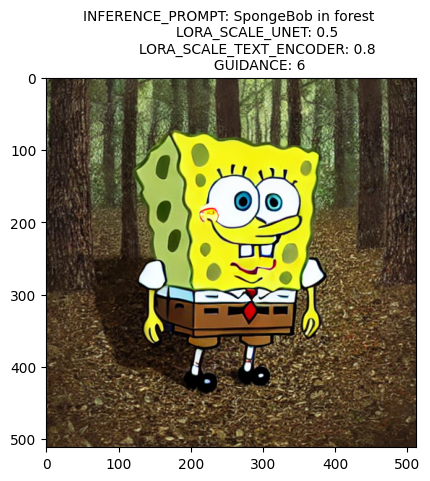

In [44]:
INFERENCE_PROMPT = 'SpongeBob in forest' #@param {type:"string"}
LORA_SCALE_UNET = 0.5 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.8 #@param {type:"number"}
GUIDANCE = 6 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
plt.imshow(image)
plt.imshow(image)
plt.title(f"INFERENCE_PROMPT: {INFERENCE_PROMPT} \n \
            LORA_SCALE_UNET: {LORA_SCALE_UNET} \n \
            LORA_SCALE_TEXT_ENCODER: {LORA_SCALE_TEXT_ENCODER} \n \
            GUIDANCE: {GUIDANCE}", size=10)
plt.show()